<a href="https://colab.research.google.com/github/laylaelbaaly/NeuralStyleTransfer/blob/main/IOB_NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IOB-NST Algorithm based on the origial paper “A Neural Algorithm of Artistic Style” by Gatys et al.**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# ===========================
# IMPORT REQUIRED LIBRARIES
# ===========================
import os
import numpy as np
import time
from keras.preprocessing.image import load_img, img_to_array
# from keras.applications import vgg19
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
K = tf.keras.backend
from scipy.optimize import fmin_l_bfgs_b
from PIL import Image
import matplotlib.pyplot as plt

# ==============================
# GLOBAL SETTINGS AND CONSTANTS
# ==============================

img_height = 512
result_prefix = "results"

# Lists to track losses and LPIPS score approximation
content_losses = []
style_losses = []
lpips_scores = []

# Weighting factors for each loss term
# content_weight = 0.025
# style_weight = 1.0
# total_variation_weight = 1e-4

# Define dataset directories

# Set content and style image folders in Google Drive
content_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/content'
style_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/style'

# Output folder (where stylized images will be saved)
output_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/stylized_outputs'
os.makedirs(output_dir, exist_ok=True)

In [10]:
# ===================================
# IMAGE PROCESSING UTILITY FUNCTIONS
# ===================================

def preprocess_image(image_path, target_size):
    """
    Loads and preprocesses an image for VGG19.
    """
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

def deprocess_image(x):
    """
    Reverses VGG19 preprocessing to return a displayable image.
    """
    x = x.reshape((img_height, img_width, 3))
    x[:, :, 0] += 103.939  # Add mean RGB values (reverse normalization)
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]      # Convert BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return Image.fromarray(x)

In [11]:
# ==============================
# LOSS FUNCTION DEFINITIONS
# ==============================

def content_loss(base, combination):
    """
    Measures content similarity (high-level feature maps).
    """
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    """
    Computes the Gram matrix (feature correlation matrix).
    """
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features))

def style_loss(style, combination):
    """
    Measures style similarity via Gram matrix difference.
    """
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    """
    Encourages spatial smoothness in the generated image.
    """
    a = K.square(x[:, :img_height-1, :img_width-1, :] - x[:, 1:, :img_width-1, :])
    b = K.square(x[:, :img_height-1, :img_width-1, :] - x[:, :img_height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# Approximate LPIPS using mean absolute error in [0, 1] space
def compute_lpips(tf_image1, tf_image2):
    img1 = tf.clip_by_value(tf_image1 / 255.0, 0.0, 1.0)
    img2 = tf.clip_by_value(tf_image2 / 255.0, 0.0, 1.0)
    return tf.reduce_mean(tf.abs(img1 - img2)).numpy()

def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.plot(content_losses, label='Content Loss')
    plt.plot(style_losses, label='Style Loss')
    plt.plot(lpips_scores, label='LPIPS Approx (Abs Diff)', linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('Loss / Score')
    plt.title('Style Transfer Metrics Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
# ===================================
# EVALUATOR: WRAPS LOSS AND GRADIENT
# ===================================

class Evaluator(object):
    """
    Used to interface with L-BFGS optimizer: returns loss and gradient separately,
    while caching them to avoid recomputation.
    """
    def __init__(self, fetch_loss_and_grads_fn):
        self.fetch_loss_and_grads = fetch_loss_and_grads_fn
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        """
        Returns the loss value and caches the gradients.
        """
        x = x.reshape((1, img_height, img_width, 3))
        outs = self.fetch_loss_and_grads([x])
        self.loss_value = outs[0]
        self.grads_values = outs[1].flatten().astype('float64')
        return self.loss_value

    def grads(self, x):
        """
        Returns cached gradients from the last loss computation.
        """
        grads = np.copy(self.grads_values)
        self.loss_value = None
        self.grads_values = None
        return grads

In [13]:
# # ===================================
# # NEURAL STYLE TRANSFER FUNCTION
# # ===================================

# def run_style_transfer(content_path, style_path, output_path,
#                        content_weight, style_weight, total_variation_weight,
#                        iterations=300):

#     global img_width
#     width, height = load_img(content_path).size
#     img_width = int(width * img_height / height)

#     # Preprocess content and style images
#     content_image = preprocess_image(content_path, (img_height, img_width))
#     style_image = preprocess_image(style_path, (img_height, img_width))

#     # Initialize the combination image as a trainable variable
#     combination_image = tf.Variable(content_image, dtype=tf.float32)

#     # Load VGG19 and freeze layers
#     vgg = vgg19.VGG19(weights='imagenet', include_top=False)
#     vgg.trainable = False

#     # Layers to extract features from
#     content_layer = 'block5_conv2'
#     style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
#     output_layers = [content_layer] + style_layers

#     # Build model that outputs selected layer activations
#     outputs = [vgg.get_layer(name).output for name in output_layers]
#     feature_extractor = Model(inputs=vgg.input, outputs=outputs)

#     # Extract features for content and style images
#     content_features = feature_extractor(content_image)[0]
#     style_features = feature_extractor(style_image)[1:]

#     # Updated Gram matrix computation for 4D tensors
#     def gram_matrix(tensor):
#         """
#         Computes the Gram matrix from a 4D feature map.
#         Input shape: (1, height, width, channels)
#         Output shape: (1, channels, channels)
#         """
#         assert len(tensor.shape) == 4, "Input must be 4D (batch, h, w, c)"
#         batch_size, height, width, channels = tensor.shape
#         x = tf.reshape(tensor, [batch_size, height * width, channels])
#         gram = tf.matmul(x, x, transpose_a=True)
#         return gram / tf.cast(height * width, tf.float32)

#     # Loss function + gradient computation
#     def compute_loss_and_grads():
#         with tf.GradientTape() as tape:
#             combo_outputs = feature_extractor(combination_image)
#             combo_content = combo_outputs[0]
#             combo_styles = combo_outputs[1:]

#             # Content loss: how much the content changes
#             c_loss = content_weight * tf.reduce_mean(tf.square(combo_content - content_features))

#             # Style loss: how much the textures match

#             # s_loss = 0
#             # for style_feat, combo_feat in zip(style_features, combo_styles):
#             #     S = gram_matrix(style_feat)
#             #     C = gram_matrix(combo_feat)
#             #     channels = 3
#             #     size = img_height * img_width
#             #     s_loss += tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
#             # s_loss *= style_weight / len(style_layers)

#             s_loss = 0
#             for style_feat, combo_feat in zip(style_features, combo_styles):
#                 S = gram_matrix(style_feat)
#                 C = gram_matrix(combo_feat)
#                 shape = tf.shape(combo_feat)
#                 channels = tf.cast(shape[-1], tf.float32)
#                 size = tf.cast(shape[1] * shape[2], tf.float32)
#                 s_loss += tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
#             s_loss *= style_weight / len(style_layers)


#             # Total variation loss: encourages spatial smoothness
#             tv_loss = total_variation_weight * total_variation_loss(combination_image)

#             # Final combined loss
#             total_loss = c_loss + s_loss + tv_loss

#         grads = tape.gradient(total_loss, combination_image)
#         return total_loss, grads

#     # Use Adam optimizer
#     optimizer = tf.optimizers.Adam(learning_rate=10.0)

#     # Optimization loop
#     for i in range(iterations):
#         loss, grads = compute_loss_and_grads()
#         optimizer.apply_gradients([(grads, combination_image)])
#         print(f"Iteration {i+1}, Loss: {loss.numpy():,.2f}")

#     # Save the stylized image
#     final_img = deprocess_image(combination_image.numpy())
#     final_img.save(output_path)
#     print(f"Saved: {output_path}")

# ===================================
# NEURAL STYLE TRANSFER FUNCTION
# ===================================
def run_style_transfer(content_path, style_path, output_path,
                       content_weight, style_weight, total_variation_weight,
                       iterations=300):

    global img_width
    width, height = load_img(content_path).size
    img_width = int(width * img_height / height)

    # Preprocess content and style images
    content_image = preprocess_image(content_path, (img_height, img_width))
    style_image = preprocess_image(style_path, (img_height, img_width))

    # Initialize the combination image as a trainable variable
    combination_image = tf.Variable(content_image, dtype=tf.float32)

    # Load VGG19 and freeze layers
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False

    # Layers to extract features from
    content_layer = 'block5_conv2'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    output_layers = [content_layer] + style_layers

    # Build model that outputs selected layer activations
    outputs = [vgg.get_layer(name).output for name in output_layers]
    feature_extractor = Model(inputs=vgg.input, outputs=outputs)

    # Extract features for content and style images
    content_features = feature_extractor(content_image)[0]
    style_features = feature_extractor(style_image)[1:]

    # Loss functions
    def gram_matrix(tensor):
        shape = tf.shape(tensor)
        b, h, w, c = shape[0], shape[1], shape[2], shape[3]
        features = tf.reshape(tensor, [b, h * w, c])
        gram = tf.matmul(features, features, transpose_a=True)
        return gram / tf.cast(h * w * c, tf.float32)

    def total_variation_loss(x):
        a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
        b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
        return tf.reduce_sum(tf.pow(a + b, 1.25))

    def compute_loss_and_grads():
        with tf.GradientTape() as tape:
            combo_outputs = feature_extractor(combination_image)
            combo_content = combo_outputs[0]
            combo_styles = combo_outputs[1:]

            c_loss = content_weight * tf.reduce_mean(tf.square(combo_content - content_features))

            s_loss = 0
            for s_feat, c_feat in zip(style_features, combo_styles):
                S = gram_matrix(s_feat)
                C = gram_matrix(c_feat)
                s_loss += tf.reduce_mean(tf.square(S - C))
            s_loss *= style_weight / len(style_layers)

            tv_loss = total_variation_weight * total_variation_loss(combination_image)
            total_loss = c_loss + s_loss + tv_loss

        grads = tape.gradient(total_loss, combination_image)
        return total_loss, grads, c_loss, s_loss

    # Optimizer
    optimizer = tf.optimizers.Adam(learning_rate=10.0)

    # Optimization loop
    for i in range(iterations):
        loss, grads, c_loss, s_loss = compute_loss_and_grads()
        optimizer.apply_gradients([(grads, combination_image)])

        # Track metrics
        content_losses.append(c_loss.numpy())
        style_losses.append(s_loss.numpy())
        lpips_scores.append(compute_lpips(combination_image, style_image))

        if (i + 1) % 10 == 0 or i == 0:
            print(f"Iteration {i+1}, Loss: {loss.numpy():,.2f}")

    # Save final image
    final_img = deprocess_image(combination_image.numpy())
    final_img.save(output_path)
    print(f"Saved: {output_path}")

    # Plot metrics
    plot_losses()


Processing: modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554.jpg + 83316.jpg
Iteration 1, Loss: 5,078,432,768.00
Iteration 10, Loss: 638,849,408.00
Iteration 20, Loss: 163,287,424.00
Iteration 30, Loss: 54,710,900.00
Iteration 40, Loss: 25,117,662.00
Iteration 50, Loss: 15,587,053.00
Iteration 60, Loss: 11,519,469.00
Iteration 70, Loss: 9,324,823.00
Iteration 80, Loss: 7,739,623.50
Iteration 90, Loss: 11,588,778.00
Iteration 100, Loss: 6,834,178.00
Iteration 110, Loss: 6,695,268.50
Iteration 120, Loss: 5,629,373.00
Iteration 130, Loss: 4,998,022.00
Iteration 140, Loss: 6,573,809.00
Iteration 150, Loss: 4,508,721.00
Iteration 160, Loss: 4,206,592.00
Iteration 170, Loss: 4,124,988.50
Iteration 180, Loss: 6,352,841.50
Iteration 190, Loss: 4,673,830.00
Iteration 200, Loss: 3,955,153.50
Iteration 210, Loss: 7,045,834.00
Iteration 220, Loss: 5,365,637.00
Iteration 230, Loss: 13,088,674.00
Iteration 240, Loss: 4,416,355.50
Iteration 

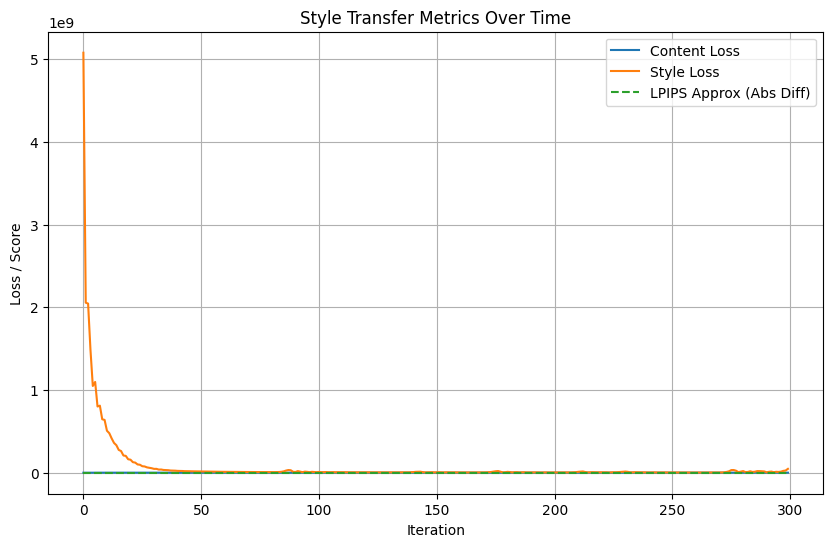


Processing: modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554.jpg + Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875.jpg
Iteration 1, Loss: 12,578,640,896.00
Iteration 10, Loss: 1,066,360,896.00
Iteration 20, Loss: 422,889,920.00
Iteration 30, Loss: 209,251,280.00
Iteration 40, Loss: 141,480,512.00
Iteration 50, Loss: 103,542,456.00
Iteration 60, Loss: 84,096,952.00
Iteration 70, Loss: 64,227,012.00
Iteration 80, Loss: 54,903,804.00
Iteration 90, Loss: 47,209,784.00
Iteration 100, Loss: 51,756,456.00
Iteration 110, Loss: 39,122,728.00
Iteration 120, Loss: 37,322,232.00
Iteration 130, Loss: 34,368,316.00
Iteration 140, Loss: 27,441,862.00
Iteration 150, Loss: 39,063,796.00
Iteration 160, Loss: 44,835,520.00
Iteration 170, Loss: 23,126,550.00
Iteration 180, Loss: 27,365,242.00
Iteration 190, Loss: 20,082,898.00
Iteration 200, Loss: 19,966,536.00
Iteration 210, Loss: 17,752,066.00
Iteration 220, Loss: 19,

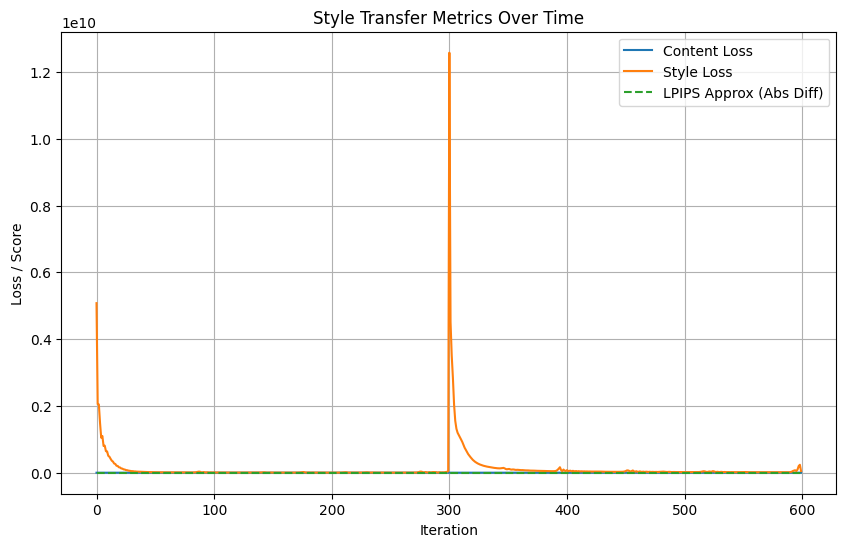


Processing: modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554.jpg + an-abstract-painting-with-bright-colours-geometric-shapes-and-bold-lines.png
Iteration 1, Loss: 9,014,706,176.00
Iteration 10, Loss: 1,406,678,656.00
Iteration 20, Loss: 597,790,080.00
Iteration 30, Loss: 307,888,064.00
Iteration 40, Loss: 195,353,344.00
Iteration 50, Loss: 138,412,048.00
Iteration 60, Loss: 106,523,568.00
Iteration 70, Loss: 86,692,024.00
Iteration 80, Loss: 82,394,856.00
Iteration 90, Loss: 69,941,592.00
Iteration 100, Loss: 59,663,744.00
Iteration 110, Loss: 52,324,600.00
Iteration 120, Loss: 51,609,636.00
Iteration 130, Loss: 51,048,972.00
Iteration 140, Loss: 49,921,484.00
Iteration 150, Loss: 43,049,100.00
Iteration 160, Loss: 38,406,080.00
Iteration 170, Loss: 50,008,732.00
Iteration 180, Loss: 40,064,056.00
Iteration 190, Loss: 37,024,620.00
Iteration 200, Loss: 36,497,828.00
Iteration 210, Loss: 31,103,060.00
Iteration 220, Loss: 81,67

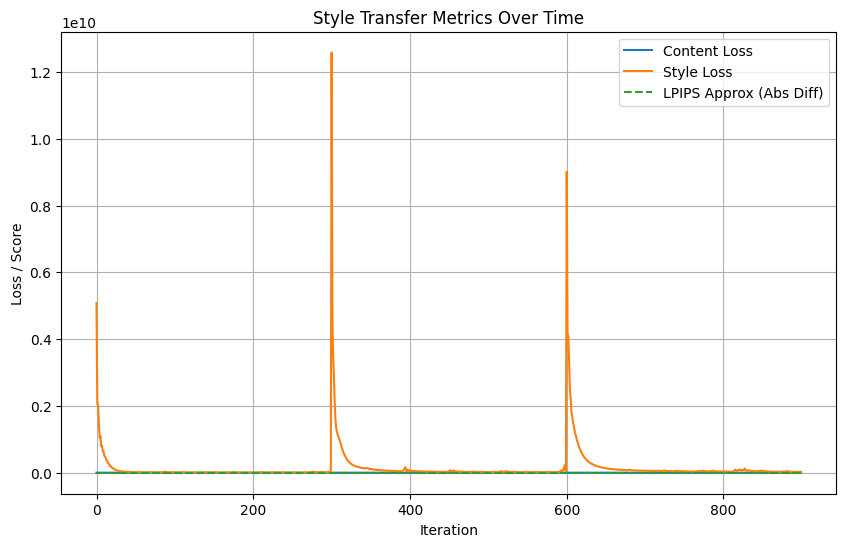

In [14]:
# ===================================
# MAIN LOOP: APPLY TO ALL IMAGE PAIRS
# ===================================

# # Sort and match files from content and style directories
# content_files = sorted([f for f in os.listdir(content_dir) if f.lower().endswith(('.jpg', '.png'))])
# style_files = sorted([f for f in os.listdir(style_dir) if f.lower().endswith(('.jpg', '.png'))])

# # Apply NST to each content-style image pair
# for content_file, style_file in zip(content_files, style_files):
#     content_path = os.path.join(content_dir, content_file)
#     style_path = os.path.join(style_dir, style_file)
#     output_path = os.path.join(output_dir, f"stylized_{content_file}_{style_file}")

#     print(f"\nProcessing: {content_file} + {style_file}")
#     run_style_transfer(content_path, style_path, output_path, 1e2, 1e5, 1e-6, 300)

# Sort all valid image files
content_files = sorted([f for f in os.listdir(content_dir) if f.lower().endswith(('.jpg', '.png'))])
style_files = sorted([f for f in os.listdir(style_dir) if f.lower().endswith(('.jpg', '.png'))])

# Apply each style to each content image
for content_file in content_files:
    for style_file in style_files:
        content_path = os.path.join(content_dir, content_file)
        style_path = os.path.join(style_dir, style_file)

        # Create a clear output filename
        output_name = f"stylized_{content_file}_with_{style_file}"
        output_path = os.path.join(output_dir, output_name)

        print(f"\nProcessing: {content_file} + {style_file}")
        run_style_transfer(content_path, style_path, output_path, 1e2, 1e5, 1e-6, 300)

In [15]:
#image is not styled enough - fix!!
#display content, style, and result
#error graphs
#surveys

#think about common final dataset for portfolio (check jing review and notes)